# Script 4 - Explore Analysis Results

_Script by Tim Hebestreit, thebestr@smail.uni-koeln.de_

This Python Notebook is used to load in the results of the sentiment analysis, aggregate the classified articles, and visualize the results.

First, _Pandas_ is imported to work with a Dataframe, and _Matplotlib_ and _Seaborn_ for plotting.

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Here, the input and output file paths are defined.

In [209]:
# --- CONFIG ---

INPUT_FILE = "../data/csv/corpus_with_sentiment.csv"
FIGURE_1_PATH = "../figures/Fig_1_Total.png"
FIGURE_2_PATH = "../figures/Fig_2_Type.png"
FIGURE_3_PATH = "../figures/Fig_3_Neg.png"
FIGURE_4_PATH = "../figures/Fig_4_Pos.png"
FIGURE_5_PATH = "../figures/Fig_5_Neu.png"
FIGURE_6_PATH = "../figures/Fig_12_Combined.png"
FIGURE_7_PATH = "../figures/Fig_345_Combined.png"
TABLE_PATH = "../figures/Yearly_Summary_Table.csv"

# Set global seaborn theme
sns.set_theme(style="whitegrid")

Load in data:

In [210]:
# --- LOAD IN DATA ---

print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Ensure that we have time data available
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

Loading data from ../data/csv/corpus_with_sentiment.csv...


To give a broad overview, we generate a table with statistics for each sentiment first.

In [211]:
# --- GENERATE OVERVIEW TABLE ---
groups = {
    "Total": df,
    "IT Press": df[df['Is_IT_Source'] == True],
    "General Press": df[df['Is_IT_Source'] == False]
}

# Pre-calculate totals per group for percentage calculation
group_totals = {name: len(dataset) for name, dataset in groups.items()}

stats_rows = []

# Iterate through sentiments (these form the rows)
sentiments = ['neutral', 'positive', 'negative']

for sent in sentiments:
    # Create a new row for this sentiment
    row = {'Sentiment': sent.capitalize()}
    
    # Get values for each group (Total, IT Press, General Press)
    for group_name, dataset in groups.items():
        # Calculate absolute count
        count = (dataset['Sentiment_Label'] == sent).sum()
        
        # Calculate percentage
        total_in_group = group_totals[group_name]
        pct = (count / total_in_group * 100) if total_in_group > 0 else 0
        
        # Add to row dictionary
        row[f'{group_name} (N)'] = count
        row[f'{group_name} (%)'] = round(pct, 2)
    
    stats_rows.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(stats_rows)

# Define column order
cols_order = [
    'Sentiment', 
    'Total (N)', 'Total (%)', 
    'IT Press (N)', 'IT Press (%)', 
    'General Press (N)', 'General Press (%)'
]
comparison_df = comparison_df[cols_order]
print("\n--- SENTIMENT COMPARISON (IT vs GENERAL) ---")
print(comparison_df.to_string(index=False))


--- SENTIMENT COMPARISON (IT vs GENERAL) ---
Sentiment  Total (N)  Total (%)  IT Press (N)  IT Press (%)  General Press (N)  General Press (%)
  Neutral      47676      88.07          6734         95.57              40942              86.95
 Positive        218       0.40             6          0.09                212               0.45
 Negative       6239      11.53           306          4.34               5933              12.60


Now, we create a table to evaluate the temporal evolution.

In [212]:
# --- GENERATE TABLE ---

print("-" * 50)
print("Generating table with yearly statistics...")
df['Year'] = df['Date'].dt.year

# Aggregate the data by year
summary = df.groupby('Year').agg(
    Total=('Title', 'count'), # Number of articles
    Neutral=('Sentiment_Label', lambda x: (x == 'neutral').sum()), # Number of neutral articles
    Negative=('Sentiment_Label', lambda x: (x == 'negative').sum()), # Number of negative articles
    Positive=('Sentiment_Label', lambda x: (x == 'positive').sum()), # Number of positive articles
    IT_Sources=('Is_IT_Source', 'sum'), # Number of articles from IT sources
    Avg_Confidence=('Sentiment_Score', 'mean') # How certain the model was on average
)

# Calculate percentages
summary['Neutral_%'] = (summary['Neutral'] / summary['Total']) * 100
summary['Negative_%'] = (summary['Negative'] / summary['Total']) * 100
summary['Positive_%'] = (summary['Positive'] / summary['Total']) * 100
summary['IT_Share_%'] = (summary['IT_Sources'] / summary['Total']) * 100

# Order columns (to improve readability)
cols_order = [
    'Total', 
    'Neutral', 'Neutral_%', 
    'Negative', 'Negative_%', 
    'Positive', 'Positive_%',
    'IT_Sources', 'IT_Share_%',
    'Avg_Confidence'
]

# Apply ordering and round to 2 decimal places
summary = summary[cols_order].round(2)

# Speichern und Anzeigen
summary.to_csv(TABLE_PATH)
print("\n--- YEARLY SUMMARY STATISTICS: ---")
print(summary)
print(f"\nSaved table at: {TABLE_PATH}")
print("-" * 50)

--------------------------------------------------
Generating table with yearly statistics...

--- YEARLY SUMMARY STATISTICS: ---
      Total  Neutral  Neutral_%  Negative  Negative_%  Positive  Positive_%  \
Year                                                                          
2015     87       71      81.61        16       18.39         0        0.00   
2016   1168      954      81.68       204       17.47        10        0.86   
2017   2352     2021      85.93       324       13.78         7        0.30   
2018   4215     3700      87.78       498       11.81        17        0.40   
2019   4269     3805      89.13       453       10.61        11        0.26   
2020   3023     2697      89.22       320       10.59         6        0.20   
2021   3167     2870      90.62       287        9.06        10        0.32   
2022   3203     2848      88.92       340       10.62        15        0.47   
2023   9251     7939      85.82      1260       13.62        52        0.56   
2

We define a helper function to get the share of sentiment per month for plotting.

In [213]:
# --- HELPER FUNCTION ---

def get_monthly_sentiment_share(dataframe, label_prefix="Total", target_sentiment='negative'):
    if len(dataframe) == 0: return None

    # Aggregate by month and return the share of the total count
    grouped = dataframe.groupby([pd.Grouper(key='Date', freq='M'), 'Sentiment_Label']).size().unstack(fill_value=0)
    grouped['Total_Count'] = grouped.sum(axis=1)
    grouped = grouped[grouped['Total_Count'] > 0]
    share = (grouped.get(target_sentiment, 0) / grouped['Total_Count']) * 100
    return share.rename(label_prefix)

This helper function is now applied to calculate the share of negative and positive articles for all articles and IT sources. This will then be used to plot the data.

In [214]:
# --- CALCULATE DATAFRAME FOR PLOTS ---

# Negative shares of articles (all, general and IT articles)
share_all_neg = get_monthly_sentiment_share(df, "All_Neg", 'negative')
share_it_neg = get_monthly_sentiment_share(df[df['Is_IT_Source'] == True], "IT_Neg", 'negative')
share_gen_neg = get_monthly_sentiment_share(df[df['Is_IT_Source'] == False], "Gen_Neg", 'negative')

# Positive shares of articles (all, general and IT articles)
share_all_pos = get_monthly_sentiment_share(df, "All_Pos", 'positive')
share_it_pos = get_monthly_sentiment_share(df[df['Is_IT_Source'] == True], "IT_Pos", 'positive')
share_gen_pos = get_monthly_sentiment_share(df[df['Is_IT_Source'] == False], "Gen_Pos", 'positive')

# Neutral shares of articles (all, general and IT articles)
share_all_neu = get_monthly_sentiment_share(df, "All_Neu", 'neutral')
share_it_neu = get_monthly_sentiment_share(df[df['Is_IT_Source'] == True], "IT_Neu", 'neutral')
share_gen_neu = get_monthly_sentiment_share(df[df['Is_IT_Source'] == False], "Gen_Neu", 'neutral')

# Combine into a plot Dataframe
comparison_df = pd.concat([share_all_neg, share_it_neg, share_gen_neg, 
                           share_all_pos, share_it_pos, share_gen_pos,share_all_neu, share_it_neu, share_gen_neu], axis=1)

# Calculate rolling average for all columns (over 6 months)
for col in comparison_df.columns:
    comparison_df[f'{col}_Rolling'] = comparison_df[col].rolling(window=6).mean()

Now we create two plots to plot the share of each sentiment and source type per month.

Creating Plot 1: Articles per Sentiment...
Figure saved at:
../figures/Fig_1_Total.png
../figures/Fig_1_Total.png


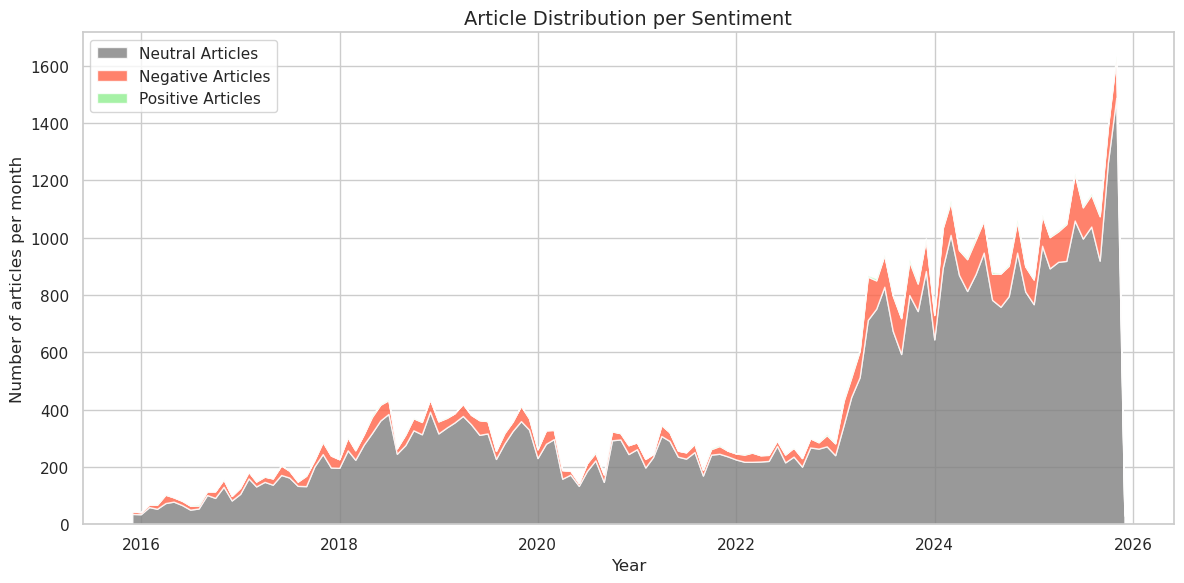

In [215]:
# --- PLOT 1 ---

print("Creating Plot 1: Articles per Sentiment...")
plt.figure(figsize=(12, 6))

# Group sentiment by month
sentiment_counts = df.groupby([pd.Grouper(key='Date', freq='M'), 'Sentiment_Label']).size().unstack(fill_value=0)

# Define colors
colors = {"neutral": "grey", "negative": "tomato", "positive": "lightgreen"}

# Define the stackplot to show all articles with stacks for each sentiment
plt.stackplot(sentiment_counts.index, 
              sentiment_counts.get("neutral", 0), 
              sentiment_counts.get("negative", 0), 
              sentiment_counts.get("positive", 0),
              labels=["Neutral Articles", "Negative Articles", "Positive Articles"],
              colors=[colors["neutral"], colors["negative"], colors["positive"]],
              alpha=0.8)

# Define title, labels and legend
plt.title("Article Distribution per Sentiment", fontsize=14)
plt.ylabel("Number of articles per month")
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.tight_layout()

# Save and close plot (to avoid mixing of plots)
plt.savefig(FIGURE_1_PATH, dpi=300)
print(f"Figure saved at:\n{FIGURE_1_PATH}")
print(FIGURE_1_PATH)
plt.show()
plt.close()

Creating Plot 2: Articles by Source Type...
Figure saved at:
../figures/Fig_2_Type.png
../figures/Fig_2_Type.png


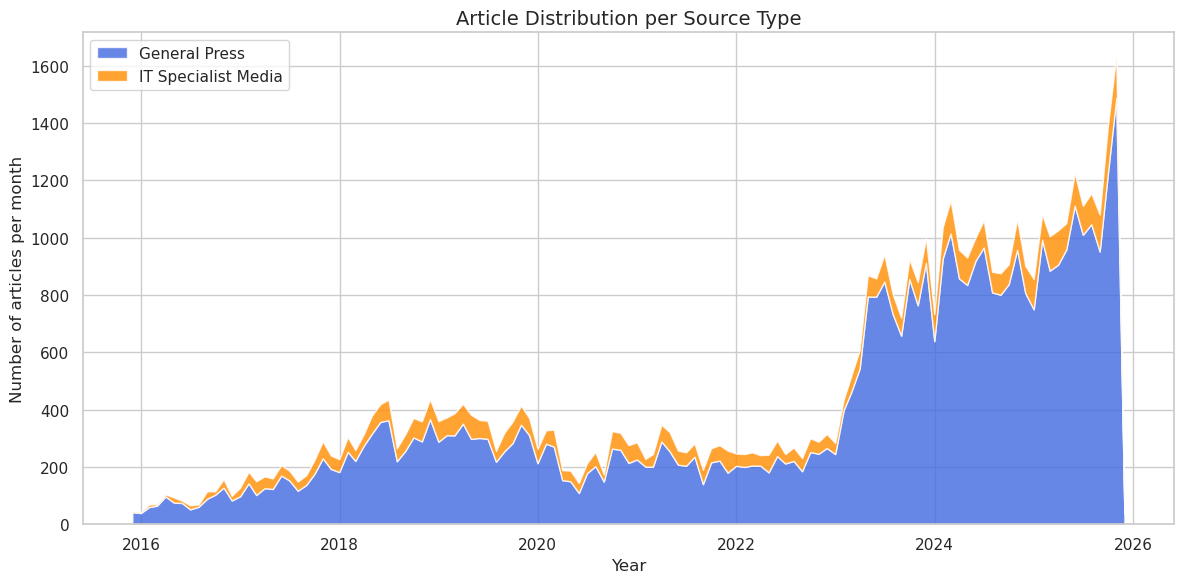

In [216]:
# --- PLOT 2 ---

print("Creating Plot 2: Articles by Source Type...")
plt.figure(figsize=(12, 6))

# Group by Month and Source Type
source_counts = df.groupby([pd.Grouper(key='Date', freq='M'), 'Is_IT_Source']).size().unstack(fill_value=0)

colors = {"general": "royalblue", "it": "darkorange"}

# Define the Stackplot to show all articles with stacks for source type
plt.stackplot(source_counts.index, 
              source_counts.get(False, 0), 
              source_counts.get(True, 0),
              labels=["General Press", "IT Specialist Media"],
              colors=[colors["general"], colors["it"]],
              alpha=0.8)

# Define title, labels and legend
plt.title("Article Distribution per Source Type", fontsize=14)
plt.ylabel("Number of articles per month")
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.tight_layout()

# Save and close plot (to avoid mixing of plots)
plt.savefig(FIGURE_2_PATH, dpi=300)
print(f"Figure saved at:\n{FIGURE_2_PATH}")
print(FIGURE_2_PATH)
plt.show()
plt.close()

 And finally, we generate three more plots to visualize the trend for negative, positive, and neutral sentiment over time.

Creating Plot 3: Negative Sentiment over Time...
Figure saved at:
../figures/Fig_3_Neg.png


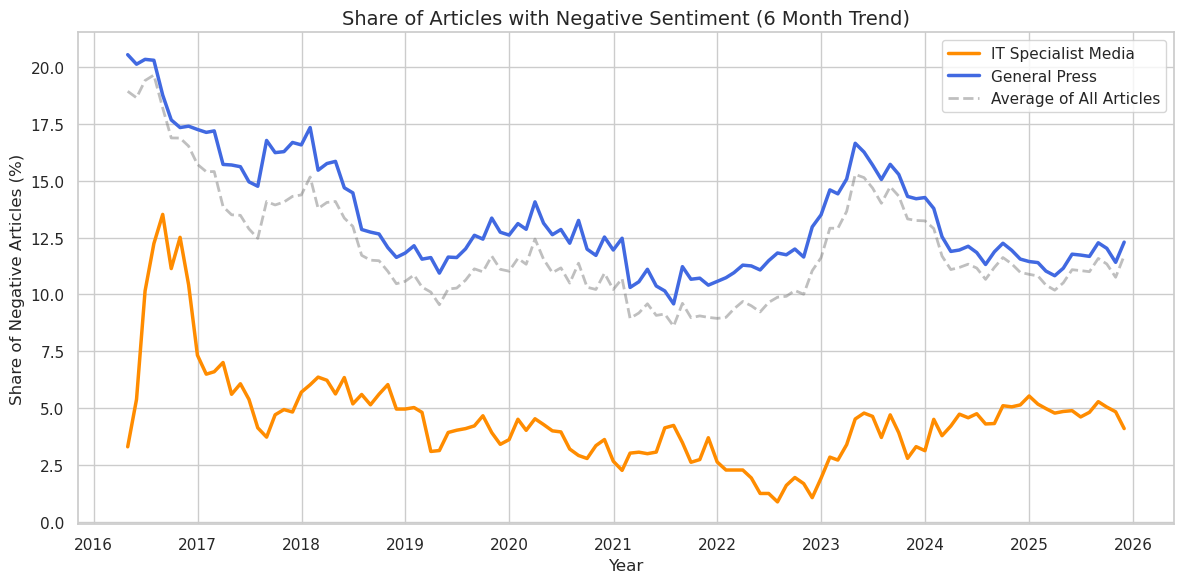

In [217]:
# --- PLOT 3 ---

print("Creating Plot 3: Negative Sentiment over Time...")
plt.figure(figsize=(12, 6))

# Create lineplots from the comparison Dataframe
sns.lineplot(data=comparison_df, x=comparison_df.index, y='IT_Neg_Rolling', 
             color="darkorange", linewidth=2.5, label="IT Specialist Media")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='Gen_Neg_Rolling', 
             color="royalblue", linewidth=2.5, label="General Press")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='All_Neg_Rolling', 
             color="gray",  linestyle="--", linewidth=2, alpha=0.5, label="Average of All Articles")

# Define title, labels and legend
plt.title("Share of Articles with Negative Sentiment (6 Month Trend)", fontsize=14)
plt.ylabel("Share of Negative Articles (%)")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.tight_layout()

# Save and close plot (to avoid mixing of plots)
plt.savefig(FIGURE_3_PATH, dpi=300)
print(f"Figure saved at:\n{FIGURE_3_PATH}")
plt.show()
plt.close()

Creating Plot 4: Positive Sentiment over Time...
Figure saved at:
../figures/Fig_4_Pos.png


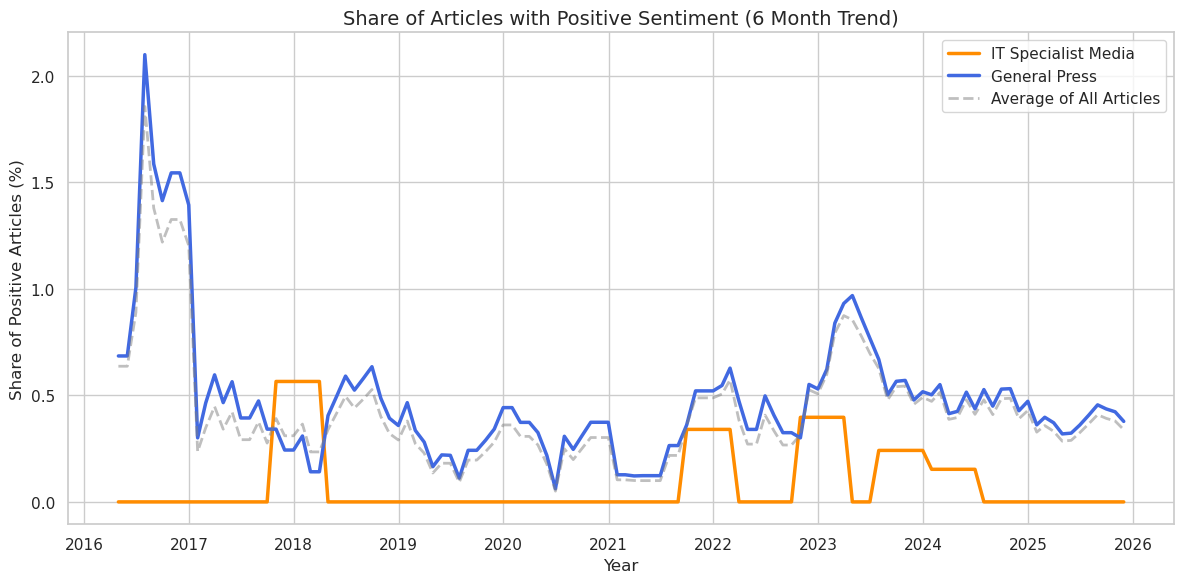

In [218]:
# --- PLOT 4 ---

print("Creating Plot 4: Positive Sentiment over Time...")
plt.figure(figsize=(12, 6))

# Create lineplots from the comparison Dataframe
sns.lineplot(data=comparison_df, x=comparison_df.index, y='IT_Pos_Rolling', 
             color="darkorange", linewidth=2.5, label="IT Specialist Media")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='Gen_Pos_Rolling', 
             color="royalblue", linewidth=2.5, label="General Press")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='All_Pos_Rolling', 
             color="gray", linewidth=2, linestyle="--", alpha=0.5, label="Average of All Articles")

# Define title, labels and legend
plt.title("Share of Articles with Positive Sentiment (6 Month Trend)", fontsize=14)
plt.ylabel("Share of Positive Articles (%)")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.tight_layout()

# Save and close plot (to avoid mixing of plots)
plt.savefig(FIGURE_4_PATH, dpi=300)
print(f"Figure saved at:\n{FIGURE_4_PATH}")
plt.show()
plt.close()

Creating Plot 5: Neutral Sentiment over Time...
Figure saved at:
../figures/Fig_5_Neu.png


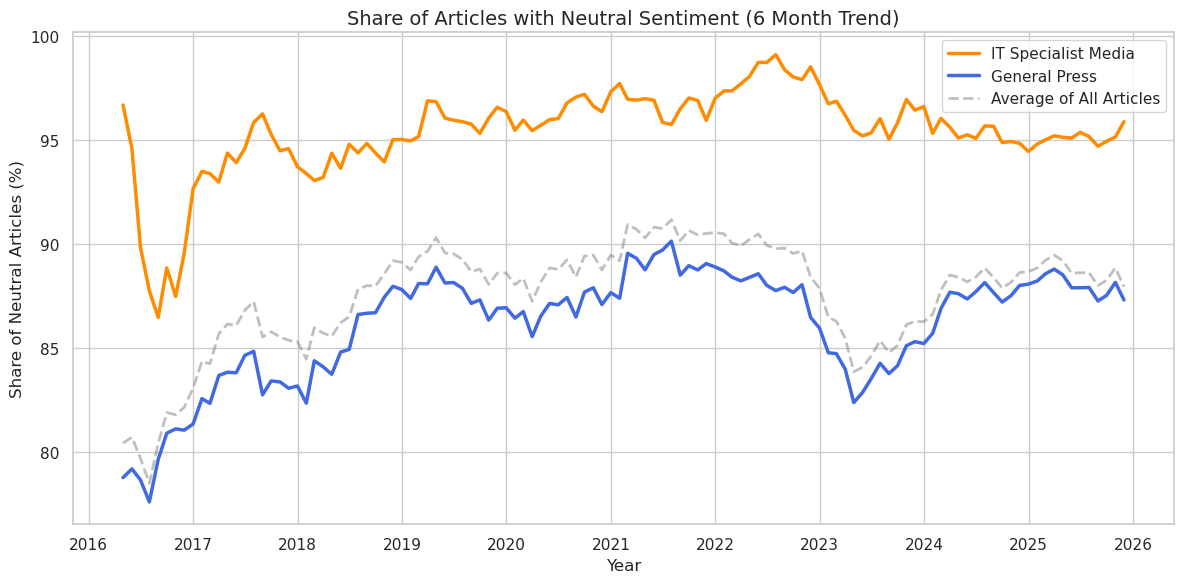

In [219]:
# --- PLOT 5 ---

print("Creating Plot 5: Neutral Sentiment over Time...")
plt.figure(figsize=(12, 6))

# Create lineplots from the comparison Dataframe
sns.lineplot(data=comparison_df, x=comparison_df.index, y='IT_Neu_Rolling', 
             color="darkorange", linewidth=2.5, label="IT Specialist Media")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='Gen_Neu_Rolling', 
             color="royalblue", linewidth=2.5, label="General Press")
sns.lineplot(data=comparison_df, x=comparison_df.index, y='All_Neu_Rolling', 
             color="gray", linewidth=2, linestyle="--", alpha=0.5, label="Average of All Articles")

# Define title, labels and legend
plt.title("Share of Articles with Neutral Sentiment (6 Month Trend)", fontsize=14)
plt.ylabel("Share of Neutral Articles (%)")
plt.xlabel("Year")
plt.legend(loc="upper right")
plt.tight_layout()

# Save and close plot (to avoid mixing of plots)
plt.savefig(FIGURE_5_PATH, dpi=300)
print(f"Figure saved at:\n{FIGURE_5_PATH}")
plt.show()
plt.close()

To display it more easily in the thesis, we create a combined plot of the first two previous figures:

Creating Combined Plot: Article Distribution (Sentiment & Source)...
Saved combined plot.


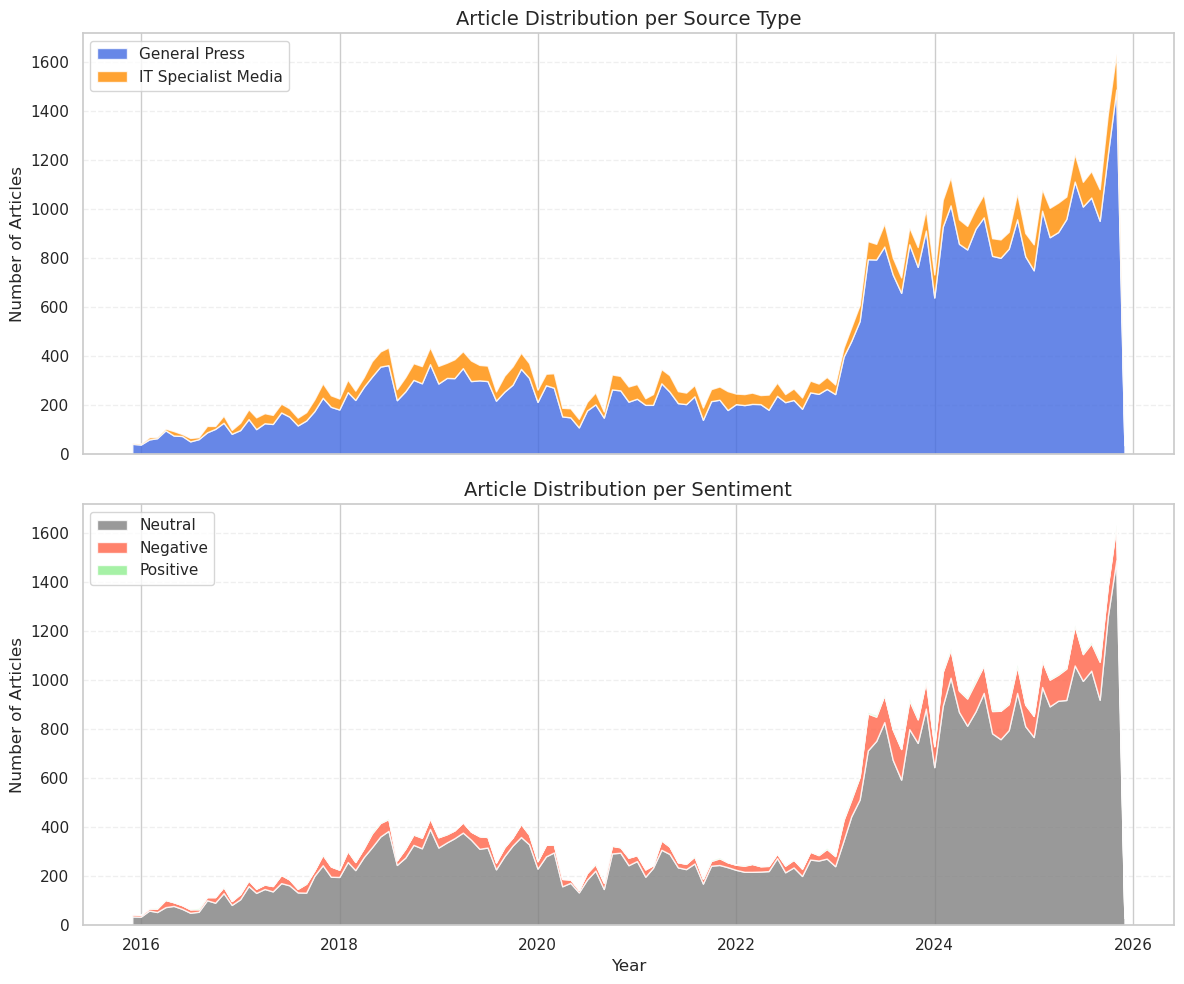

In [220]:
print("Creating Combined Plot: Article Distribution (Sentiment & Source)...")

# Group sentiment by month
sentiment_counts = df.groupby([pd.Grouper(key='Date', freq='M'), 'Sentiment_Label']).size().unstack(fill_value=0)
# Group by Source Type by month
source_counts = df.groupby([pd.Grouper(key='Date', freq='M'), 'Is_IT_Source']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# --- SUBPLOT 1: Source Type ---

colors_source = {"general": "royalblue", "it": "darkorange"}

axes[0].stackplot(source_counts.index, 
                  source_counts.get(False, 0), 
                  source_counts.get(True, 0),
                  labels=["General Press", "IT Specialist Media"],
                  colors=[colors_source["general"], colors_source["it"]],
                  alpha=0.8)

axes[0].set_title("Article Distribution per Source Type", fontsize=14)
axes[0].set_ylabel("Number of Articles")
axes[0].legend(loc="upper left")
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# --- SUBPLOT 2: Sentiment ---

colors_sent = {"neutral": "grey", "negative": "tomato", "positive": "lightgreen"}

axes[1].stackplot(sentiment_counts.index, 
                  sentiment_counts.get("neutral", 0), 
                  sentiment_counts.get("negative", 0), 
                  sentiment_counts.get("positive", 0),
                  labels=["Neutral", "Negative", "Positive"],
                  colors=[colors_sent["neutral"], colors_sent["negative"], colors_sent["positive"]],
                  alpha=0.8)

axes[1].set_title("Article Distribution per Sentiment", fontsize=14)
axes[1].set_ylabel("Number of Articles")
axes[1].set_xlabel("Year")
axes[1].legend(loc="upper left")
axes[1].grid(axis='y', linestyle='--', alpha=0.3) 



plt.tight_layout()
plt.savefig(FIGURE_6_PATH, dpi=300)
print("Saved combined plot.")
plt.show()
plt.close()

And the same is done for the plot 3,4, and 5.

Creating Combined Sentiment Plot...
Saved combined plot.


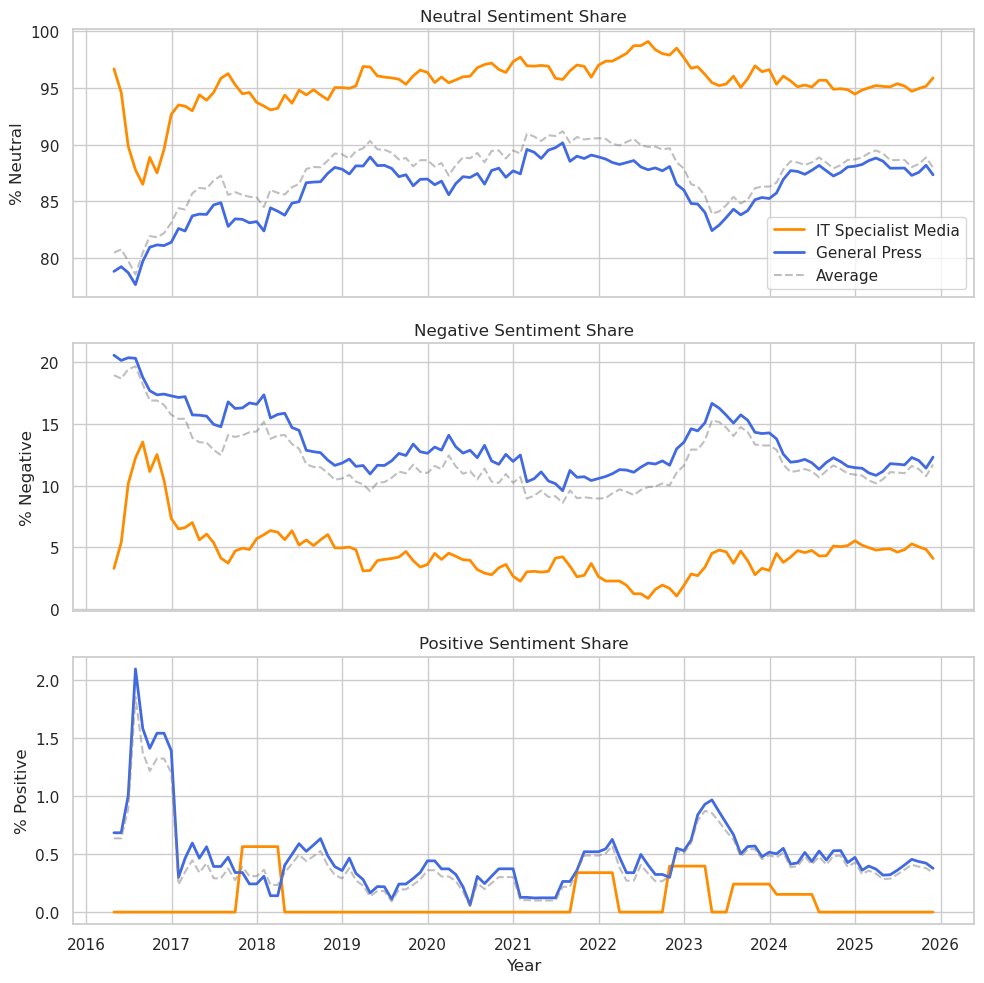

In [221]:
print("Creating Combined Sentiment Plot...")

# Create a combined figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# --- PLOT 1: NEUTRAL ---
sns.lineplot(ax=axes[0], data=comparison_df, x=comparison_df.index, y='IT_Neu_Rolling', 
             color="darkorange", linewidth=2, label="IT Specialist Media")
sns.lineplot(ax=axes[0], data=comparison_df, x=comparison_df.index, y='Gen_Neu_Rolling', 
             color="royalblue", linewidth=2, label="General Press")
sns.lineplot(ax=axes[0], data=comparison_df, x=comparison_df.index, y='All_Neu_Rolling', 
             color="gray", linewidth=1.5, linestyle="--", alpha=0.5, label="Average")
axes[0].set_title("Neutral Sentiment Share", fontsize=12)
axes[0].set_ylabel("% Neutral")
axes[0].legend(loc="lower right")

# --- PLOT 2: NEGATIVE ---
sns.lineplot(ax=axes[1], data=comparison_df, x=comparison_df.index, y='IT_Neg_Rolling', 
             color="darkorange", linewidth=2)
sns.lineplot(ax=axes[1], data=comparison_df, x=comparison_df.index, y='Gen_Neg_Rolling', 
             color="royalblue", linewidth=2)
sns.lineplot(ax=axes[1], data=comparison_df, x=comparison_df.index, y='All_Neg_Rolling', 
             color="gray", linewidth=1.5, linestyle="--", alpha=0.5)
axes[1].set_title("Negative Sentiment Share", fontsize=12)
axes[1].set_ylabel("% Negative")

# --- PLOT 3: POSITIVE ---
sns.lineplot(ax=axes[2], data=comparison_df, x=comparison_df.index, y='IT_Pos_Rolling', 
             color="darkorange", linewidth=2)
sns.lineplot(ax=axes[2], data=comparison_df, x=comparison_df.index, y='Gen_Pos_Rolling', 
             color="royalblue", linewidth=2)
sns.lineplot(ax=axes[2], data=comparison_df, x=comparison_df.index, y='All_Pos_Rolling', 
             color="gray", linewidth=1.5, linestyle="--", alpha=0.5)
axes[2].set_title("Positive Sentiment Share", fontsize=12)
axes[2].set_ylabel("% Positive")
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.savefig(FIGURE_7_PATH, dpi=300)
print("Saved combined plot.")
plt.show()
plt.close()